
![Python Logo](./ieseg_logo.png)

# Group Project - Financial Programming 
   #### By Omar Mantilla, Juliana Sanchez Ramirez & George Simonsen


This dashboard analyses each data set within the PKDD'99 financial set, and also creates and interprets indepedent and dependent variables. Furthermore, the purpose of the dashboard is to build a base table from the 8 data sets. Finally, graphs are developed in the dashboard to provide a visualisation of certain variables 


### Importing Data Packages

Each data package which is necessary for the dashboard is included below.

In [233]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing

### Importing PKDD'99 Data

In [234]:
# Import banking data

# Each record describes characteristics of a client
client = pd.read_csv('./data/raw/data_berka/client.asc', sep=';')

# Each record describes static characteristics of an account
account = pd.read_csv('./data/raw/data_berka/account.asc', sep=';')

# Each record describes a credit card issued to an account
card = pd.read_csv('./data/raw/data_berka/card.asc', sep=';')

# Each record describes demographic characteristics of a district
district = pd.read_csv('./data/raw/data_berka/district.asc', sep=';')

# Each record relates together a client with an account
# i.e. this relation describes the rights of clients to operate accounts
disp = pd.read_csv('./data/raw/data_berka/disp.asc', sep=';')

# Each record describes characteristics of a payment order (debits only)
order = pd.read_csv('./data/raw/data_berka/order.asc', sep=';')

# Each record describes one transaction on an account
trans = pd.read_csv('./data/raw/data_berka/trans.asc', sep=';', low_memory=False)

# Each record describes a loan granted for a given account
loan = pd.read_csv('./data/raw/data_berka/loan.asc', sep=';')

### DataSet Preperation

The Basetable is firstly prepared with regards to the necessary Ids in the account data set as per the selected timeline for accounts created before 1996.

In [235]:
#Create year variable (From Account DataSet)
account['year_acc'] = account['date'].astype(str).str[:2].astype(int) + 1900

#Delete accounts opened before 1996
account_96 = account[account['year_acc'] < 1996].copy(deep=True)

#Create variable length of relationship in 1996
account_96['lor'] = 1996 - account_96['year_acc']

#Rename frequency of issuance
account_96["frequency"].replace({"POPLATEK MESICNE": "monthly", 
                                 "POPLATEK TYDNE": "weekly",
                                 "POPLATEK PO OBRATU": "after_transaction"}, inplace=True)

#Print new table
account_96.head()

,account_id,district_id,frequency,date,year_acc,lor
0,576,55,monthly,930101,1993,3
1,3818,74,monthly,930101,1993,3
2,704,55,monthly,930101,1993,3
3,2378,16,monthly,930101,1993,3
4,2632,24,monthly,930102,1993,3


### DataSet 1 - Client Information

This section of the dashboard intends on developing the birth_number variable to split between year, month and day. Additionally, this section will also keep the type OWNERs of accounts which can then be added to the basetable through the client_id.


In [236]:
#Print the number of observations in the Client DataSet
print(len(client))

#Print the Client DataSet information to check for variables, null values and data types
client.info()

5369
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


Initially, we have 5369 accounts within the client data set

In [237]:
#Inner join client and disposition DataSets keeping OWNERs (clients) of accounts
cli_owners=pd.merge(client,disp[disp['type'] == 'OWNER'], how="inner", on='client_id')

#Print the number of observations of newly created DataSet (from 5369 to 4500)
print(len(cli_owners))

#Print the newly created DataSet
print(cli_owners.head())

4500
   client_id  birth_number  district_id  disp_id  account_id   type
0          1        706213           18        1           1  OWNER
1          2        450204            1        2           2  OWNER
2          4        561201            5        4           3  OWNER
3          6        190922           12        6           4  OWNER
4          7        290125           15        7           5  OWNER


After specifing that we only want OWNERS, we have 4500 observations (accounts) in our new cli_owners data set.
The next step is creating client variables: age, gender and age group

In [238]:
# Transform the birth day into year
cli_owners['birth_year'] = cli_owners['birth_number'].astype(str).str[:2].astype(int) +1900

# Extract the birth month
cli_owners['birth_month'] = cli_owners['birth_number'].astype(str).str[2:4].astype(int)

# Transform the birth day to day
cli_owners['birth_day'] = cli_owners['birth_number'].astype(str).str[-2:].astype(int)

#Creating Age variable
cli_owners['Age'] = 1996 - cli_owners['birth_year'] 

# Extract and correct the gender
cli_owners['gender'] = 'M'
cli_owners.loc[cli_owners['birth_month'] > 50, 'gender'] = 'F'

# Correct the birth month
cli_owners.loc[cli_owners['birth_month'] > 50, 'birth_month'] = cli_owners.loc[cli_owners['birth_month'] > 50, 'birth_month'] - 50

#Develop Age groups for the OWNER DataSet
cli_owners.loc[cli_owners['Age']<18,"Age_group"]="Teenagers"

cli_owners.loc[(cli_owners['Age']>=18) & (cli_owners['Age']<=25),"Age_group"]="Young adults"

cli_owners.loc[(cli_owners['Age']>25) & (cli_owners['Age']<=40),"Age_group"]="Adults"

cli_owners.loc[(cli_owners['Age']>40) & (cli_owners['Age']<=60),"Age_group"]="Middle age"

cli_owners.loc[(cli_owners['Age']>60),"Age_group"]="Senior"

#Check Age groups have no unknown observations
cli_owners['Age_group'].unique()

array(['Adults', 'Middle age', 'Senior', 'Teenagers', 'Young adults'],
      dtype=object)

In [239]:
#Print DataSet with new variables
cli_owners.head()

,client_id,birth_number,district_id,disp_id,account_id,type,birth_year,birth_month,birth_day,Age,gender,Age_group
0,1,706213,18,1,1,OWNER,1970,12,13,26,F,Adults
1,2,450204,1,2,2,OWNER,1945,2,4,51,M,Middle age
2,4,561201,5,4,3,OWNER,1956,12,1,40,M,Adults
3,6,190922,12,6,4,OWNER,1919,9,22,77,M,Senior
4,7,290125,15,7,5,OWNER,1929,1,25,67,M,Senior


The above code enables us to transform the birth_number variable into interpretable variables including the birth_year, current age (as of 1996), birth_day, birth_month, gender and Age_group.

### DataSet 2 - Card Information

The card data set has usefull information regarding the types of cards for each owner and the year that the card was issued. In turn, the variables are manipulated and added into the basetable.

In [240]:
#Print information regarding the card data set
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  892 non-null    int64 
 1   disp_id  892 non-null    int64 
 2   type     892 non-null    object
 3   issued   892 non-null    object
dtypes: int64(2), object(2)
memory usage: 28.0+ KB


In [241]:
# Extract the Card Year and month
card['issue_card_year'] = card['issued'].astype(str).str[:2].astype(int) +1900
card['issue_card_month'] = card['issued'].astype(str).str[2:4].astype(int) 


# Filter value variables before 1996
card96 = card[card['issue_card_year'] == 1996].copy(deep=True)

#Print new data set
card96.head()

,card_id,disp_id,type,issued,issue_card_year,issue_card_month
85,337,2141,classic,960101 00:00:00,1996,1
86,771,5233,classic,960108 00:00:00,1996,1
87,379,2431,classic,960112 00:00:00,1996,1
88,106,592,classic,960114 00:00:00,1996,1
89,606,3883,classic,960122 00:00:00,1996,1


In [242]:
# Merge by disp and card on disp_id to include account_id and client_id information
dis_card=pd.merge(disp,card96, how="inner", on='disp_id') 
dis_card = dis_card.rename(columns={'type_x':'client_type',
                        'type_y':'card_type'})

#Print the number of cards which have been issued
print(len(dis_card))

#Print newly merged data set
print(dis_card.head())

116
   disp_id  client_id  account_id client_type  card_id card_type  \
0       77         77          66       OWNER       10   classic   
1       83         83          71       OWNER       12    junior   
2      112        112          95       OWNER       14   classic   
3      153        153         128       OWNER       24    junior   
4      238        238         196       OWNER       37   classic   

            issued  issue_card_year  issue_card_month  
0  961207 00:00:00             1996                12  
1  960911 00:00:00             1996                 9  
2  960217 00:00:00             1996                 2  
3  960805 00:00:00             1996                 8  
4  960420 00:00:00             1996                 4  


In [243]:
# Check that there are not duplicates in the new data set
dis_card['client_id'].nunique() 

116

The above inputs enable us to determine that there are 116 cards issued to OWNERs before 1996.

In [244]:
#Calcuate LOR to determine the number of years the card has been issued
dis_card['lor_card_m'] = ((1996 - dis_card['issue_card_year']) * 12 + (12  - dis_card['issue_card_month'] ))

#Print updated data set
dis_card.head()

,disp_id,client_id,account_id,client_type,card_id,card_type,issued,issue_card_year,issue_card_month,lor_card_m
0,77,77,66,OWNER,10,classic,961207 00:00:00,1996,12,0
1,83,83,71,OWNER,12,junior,960911 00:00:00,1996,9,3
2,112,112,95,OWNER,14,classic,960217 00:00:00,1996,2,10
3,153,153,128,OWNER,24,junior,960805 00:00:00,1996,8,4
4,238,238,196,OWNER,37,classic,960420 00:00:00,1996,4,8


### DataSet 3 - Demographic Information

The third data set provides demographic information on the location of the banks throughout the Czech Republic. The variables contain a lot of information which can be useful in the basetable, and also need to be renamed to match the meaning (currently A1, A2...). 

In [245]:
#Print the district data set
district.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [246]:
#Rename variables to indicate different number meanings

district = district.rename(columns={'A1':'district_id',
                                    'A2':'district_name',
                                    'A3':'region',
                                    'A4':'nb_inhabitants',
                                    'A5':'small_municipality',
                                    'A6':'medium_municipality',
                                    'A7':'large_municipality',
                                    'A8':'vlarge_municipality',
                                    'A9':'nb_cities',
                                    'A10':'urbinhabitants_ratio',
                                    'A11':'avg_salary',
                                    'A12':'95unemp_rate',
                                    'A13':'96unemp_rate',
                                    'A14':'Entrepreneurs_per1000_inhad',
                                    'A15':'95crime_rate',
                                    'A16':'96crime_rate',
                                    })
#Print the updated data set
district.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   district_id                  77 non-null     int64  
 1   district_name                77 non-null     object 
 2   region                       77 non-null     object 
 3   nb_inhabitants               77 non-null     int64  
 4   small_municipality           77 non-null     int64  
 5   medium_municipality          77 non-null     int64  
 6   large_municipality           77 non-null     int64  
 7   vlarge_municipality          77 non-null     int64  
 8   nb_cities                    77 non-null     int64  
 9   urbinhabitants_ratio         77 non-null     float64
 10  avg_salary                   77 non-null     int64  
 11  95unemp_rate                 77 non-null     object 
 12  96unemp_rate                 77 non-null     float64
 13  Entrepreneurs_per1000_

In [247]:
#Check for duplicates
district['district_id'].nunique()

77

In [248]:
#Check (Through excel) the 69th line because the variables are objects
print(district['95unemp_rate'][68])
print(district['95crime_rate'][68])

?
?


In [249]:
#Change the '?' value to a 0
district['95unemp_rate'][68] = 0
district['95crime_rate'][68] = 0

<ipython-input-249-ac9dca42d80c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district['95unemp_rate'][68] = 0
<ipython-input-249-ac9dca42d80c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district['95crime_rate'][68] = 0


In [250]:
#Check the updated values are equal to 0
print(district['95unemp_rate'][68])
print(district['95crime_rate'][68])

0
0


In [251]:
#Transform variables into respective integer and float
district['95crime_rate'] = district['95crime_rate'].astype(int)
district['95unemp_rate'] = district['95unemp_rate'].astype(float)

In [252]:
#Transform district_name values to string for future normalization
district['district_name'][0]
district['district_name'][0] = 'Praha'
district['district_name'][0] = district['district_name'].astype(str)

<ipython-input-252-a65fb05f5859>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district['district_name'][0] = 'Praha'
<ipython-input-252-a65fb05f5859>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district['district_name'][0] = district['district_name'].astype(str)


In [253]:
#Print information to see if the data types have been updated
district.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   district_id                  77 non-null     int64  
 1   district_name                77 non-null     object 
 2   region                       77 non-null     object 
 3   nb_inhabitants               77 non-null     int64  
 4   small_municipality           77 non-null     int64  
 5   medium_municipality          77 non-null     int64  
 6   large_municipality           77 non-null     int64  
 7   vlarge_municipality          77 non-null     int64  
 8   nb_cities                    77 non-null     int64  
 9   urbinhabitants_ratio         77 non-null     float64
 10  avg_salary                   77 non-null     int64  
 11  95unemp_rate                 77 non-null     float64
 12  96unemp_rate                 77 non-null     float64
 13  Entrepreneurs_per1000_

In [254]:
#Create different variables from the district information

#Create variable on the % of crime from the number of inhabitants per region in 1995
district['crimepct95'] = round(district['95crime_rate'] / district['nb_inhabitants'] * 100,2)

#Create variable on the % of crime from the number of inhabitants per region in 1996
district['crimepct96'] = round(district['96crime_rate'] / district['nb_inhabitants'] * 100,2)

#Create variable which shows the change in crime rate per region from 1995 to 1996
district['crime_pctchange'] = round(district['crimepct96'] - district['crimepct95'],2)

#Create variable which shows the change in unemployment rate per region from 1995 to 1996
district['unemp_pctchange'] = round(district['96unemp_rate'] - district['95unemp_rate'],2)

#Print updated data set
district.head()

,district_id,district_name,region,nb_inhabitants,small_municipality,medium_municipality,large_municipality,vlarge_municipality,nb_cities,urbinhabitants_ratio,avg_salary,95unemp_rate,96unemp_rate,Entrepreneurs_per1000_inhad,95crime_rate,96crime_rate,crimepct95,crimepct96,crime_pctchange,unemp_pctchange
0,1,0 Praha 1 Benesov 2 ...,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107,7.11,8.22,1.11,0.14
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674,2.43,3.01,0.58,0.18
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813,3.75,3.74,-0.01,0.26
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892,3.50,3.93,0.43,0.41
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040,2.74,3.18,0.44,0.58


In [255]:
#Normalize large variables Avg_Salary and Nb_Inhabitants
district['nb_inhabitants']=district['nb_inhabitants'] / district['nb_inhabitants'].max()
district['avg_salary']=district['avg_salary'] / district['avg_salary'].max()

The updated data set includes the newly calculated variables. However, for the purpose of the analysis, certain variables need to be cut due to irrelevance.

In [256]:
#Check there are no issues with newly created variables
district.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   district_id                  77 non-null     int64  
 1   district_name                77 non-null     object 
 2   region                       77 non-null     object 
 3   nb_inhabitants               77 non-null     float64
 4   small_municipality           77 non-null     int64  
 5   medium_municipality          77 non-null     int64  
 6   large_municipality           77 non-null     int64  
 7   vlarge_municipality          77 non-null     int64  
 8   nb_cities                    77 non-null     int64  
 9   urbinhabitants_ratio         77 non-null     float64
 10  avg_salary                   77 non-null     float64
 11  95unemp_rate                 77 non-null     float64
 12  96unemp_rate                 77 non-null     float64
 13  Entrepreneurs_per1000_

In [257]:
#Remove unnecesary variables
district=district.drop(['95crime_rate','crimepct95','95unemp_rate','96crime_rate'],axis=1)

In [258]:
#Print updated district data set
district.head()

,district_id,district_name,region,nb_inhabitants,small_municipality,medium_municipality,large_municipality,vlarge_municipality,nb_cities,urbinhabitants_ratio,avg_salary,96unemp_rate,Entrepreneurs_per1000_inhad,crimepct96,crime_pctchange,unemp_pctchange
0,1,0 Praha 1 Benesov 2 ...,Prague,1.000000,0,0,0,1,1,100.0,1.000000,0.43,167,8.22,1.11,0.14
1,2,Benesov,central Bohemia,0.073766,80,26,6,2,5,46.7,0.678335,1.85,132,3.01,0.58,0.18
2,3,Beroun,central Bohemia,0.062436,55,26,4,1,5,41.7,0.716051,2.21,111,3.74,-0.01,0.26
3,4,Kladno,central Bohemia,0.124397,63,29,6,2,6,67.4,0.777689,5.05,109,3.93,0.43,0.41
4,5,Kolin,central Bohemia,0.079352,65,30,4,1,6,51.4,0.742126,4.43,118,3.18,0.44,0.58


### DataSet 4 - Payment Order Characteristics

The dataset regarding payments orders provides the types of transactions which have occured for each client.

In [259]:
#Print order data set
print(order.head())
len(order)

   order_id  account_id bank_to  account_to  amount k_symbol
0     29401           1      YZ    87144583  2452.0     SIPO
1     29402           2      ST    89597016  3372.7     UVER
2     29403           2      QR    13943797  7266.0     SIPO
3     29404           3      WX    83084338  1135.0     SIPO
4     29405           3      CD    24485939   327.0         


6471

It can be observed that 6471 orders have been conducted within the dataset to a number of different banks with regards to a number of different transaction types.

In [260]:
#Rename the empty K_symbol values and abbreviated transaction types
order['k_symbol'] = order['k_symbol'].replace({' ' : 'NonSpecific',
                                               'POJISTNE' : 'Insurance',
                                               'SIPO' : 'Household',
                                               'LEASING' : 'Leasing',
                                               'UVER' : 'Loan'})
order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,2452.0,Household
1,29402,2,ST,89597016,3372.7,Loan
2,29403,2,QR,13943797,7266.0,Household
3,29404,3,WX,83084338,1135.0,Household
4,29405,3,CD,24485939,327.0,NonSpecific


In [261]:
#Pivot table with the amount of orders per k symbol
order_amount=order.pivot_table(index="account_id", columns=["k_symbol"],values="amount", aggfunc = sum).reset_index()
order_amount=order_amount.fillna({'Household':0, 'Insurance':0, 'Leasing':0, 'Loan':0, 'NonSpecific':0}).fillna(0)
order_amount.head()

k_symbol,account_id,Household,Insurance,Leasing,Loan,NonSpecific
0,1,2452.0,0.0,0.0,0.0,0.0
1,2,7266.0,0.0,0.0,3372.7,0.0
2,3,1135.0,3539.0,0.0,0.0,327.0
3,4,3363.0,0.0,0.0,0.0,0.0
4,5,2668.0,0.0,0.0,0.0,0.0


In [262]:
#Concatenate the data set in order to count the number, and types of transactions per customer_id
order_ptype = pd.concat([pd.get_dummies(order.k_symbol), order], axis=1).drop('k_symbol', axis = 1)

#Print concatinated data frame
order_ptype.head()

,Household,Insurance,Leasing,Loan,NonSpecific,order_id,account_id,bank_to,account_to,amount
0,1,0,0,0,0,29401,1,YZ,87144583,2452.0
1,0,0,0,1,0,29402,2,ST,89597016,3372.7
2,1,0,0,0,0,29403,2,QR,13943797,7266.0
3,1,0,0,0,0,29404,3,WX,83084338,1135.0
4,0,0,0,0,1,29405,3,CD,24485939,327.0


In [263]:
#Pivot the data set in order to count the number, and types of orders per customer_id
order_ptype_pivot = order_ptype.pivot_table(values = ['Household','Insurance','Leasing','Loan','NonSpecific', 'amount'], index='account_id', aggfunc = sum)
order_ptype_pivot=order_ptype_pivot.reset_index()
#Print pivoted data frame
order_ptype_pivot.head()

,account_id,Household,Insurance,Leasing,Loan,NonSpecific,amount
0,1,1,0,0,0,0,2452.0
1,2,1,0,0,1,0,10638.7
2,3,1,1,0,0,1,5001.0
3,4,2,0,0,0,0,3363.0
4,5,1,0,0,0,0,2668.0


The above table provides a picture for all the accounts with regards to the number of debits per type, and the total amount for all debits by that account.

In [264]:
#Observe the number of debits to each bank
order['bank_to'].value_counts()

QR    531
YZ    521
AB    519
WX    515
ST    511
KL    500
UV    499
IJ    496
GH    487
OP    485
EF    483
MN    466
CD    458
Name: bank_to, dtype: int64

In [265]:
#Repeat process for the different banks to see the number of orders per account to each bank
order_bank = pd.concat([pd.get_dummies(order.bank_to), order], axis=1).drop('bank_to', axis = 1)

#Print data set
order_bank.head()

,AB,CD,EF,GH,IJ,KL,MN,OP,QR,ST,UV,WX,YZ,order_id,account_id,account_to,amount,k_symbol
0,0,0,0,0,0,0,0,0,0,0,0,0,1,29401,1,87144583,2452.0,Household
1,0,0,0,0,0,0,0,0,0,1,0,0,0,29402,2,89597016,3372.7,Loan
2,0,0,0,0,0,0,0,0,1,0,0,0,0,29403,2,13943797,7266.0,Household
3,0,0,0,0,0,0,0,0,0,0,0,1,0,29404,3,83084338,1135.0,Household
4,0,1,0,0,0,0,0,0,0,0,0,0,0,29405,3,24485939,327.0,NonSpecific


In [266]:
#Pivot the data set in order to count the number, and types of debits per customer_id
order_bank_pivot = order_bank.pivot_table(values = ['QR',
                                                      'YZ',
                                                      'AB',
                                                      'WX',
                                                      'ST',
                                                      'KL',
                                                      'UV',
                                                      'IJ',
                                                      'GH',
                                                      'OP',
                                                      'EF',
                                                      'MN',
                                                      'CD',
                                                      ], index='account_id', aggfunc = sum)
#Print data set
order_bank_pivot=order_bank_pivot.reset_index()

The table above shows the number of debits per account to each of the 13 banks.

### DataSet 5 - Transaction Information

The transaction data set has in-depth information regarding transaction information as per the client.

In [267]:
# Copy of Transaction Table
trans96=trans

# Extract the Transaction Year
trans96['trans_year'] = trans['date'].astype(str).str[:2].astype(int) +1900

# Extract the Transaction Day
trans96['trans_day'] = trans['date'].astype(str).str[-2:].astype(int)

# Extract the Transaction Month
trans96['trans_month'] = trans['date'].astype(str).str[2:4].astype(int)

# Filter value variables before 1996
trans96 = trans96[trans96['trans_year'] == 1996].copy(deep=True)

In [268]:
# In the Transactions per Type values we noticed that there is a VYBER value that should not be there.
# This is Based on the fact that in the data description file, it is mentioned that the type variable only has two data type:
# "PRIJEM" stands for credit
# "VYDAJ" stands for withdrawal
# Assuming that VYBER is also specified as withdrawal in cash, we need to replace it for VYDAJ. 
# Replaced VYBER per VYDAJ 
trans96['type'].replace('VYBER', 'VYDAJ', inplace=True)

In [269]:
# Type Value verification
trans96['type'].value_counts()

VYDAJ     119815
PRIJEM     76964
Name: type, dtype: int64

In [270]:
#treatinG missing values 
trans96["operation"].fillna("Other", inplace = True)
trans96["k_symbol"].fillna("Other", inplace = True)
trans96["bank"].fillna("NA", inplace = True)
trans96["account"].fillna("NA", inplace = True)

#### Print Transactions Data Set

In [271]:
trans96.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,trans_year,trans_day,trans_month
252855,732811,2504,960101,VYDAJ,VYBER KARTOU,900.0,38124.4,Other,NA,0.0,1996,1,1
252856,800209,2729,960101,VYDAJ,VYBER,1920.0,34202.7,Other,NA,NA,1996,1,1
252857,803553,2738,960101,VYDAJ,VYBER,6500.0,25685.2,Other,NA,NA,1996,1,1
252858,1042686,3566,960101,VYDAJ,VYBER,1000.0,25919.7,Other,NA,NA,1996,1,1
252859,1042689,3566,960101,VYDAJ,VYBER,500.0,25419.7,Other,NA,NA,1996,1,1


In [272]:
# Number of Transactions per account and month in 1996
trans_per_month = trans96.pivot_table(index="account_id", columns=["trans_month"],values="amount", aggfunc = 'count').reset_index()
# Replace NaN with 0
trans_per_month=trans_per_month.replace(np.nan, 0)
# Print the trans_per_month head
trans_per_month.head()

trans_month,account_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1,12.0,5.0,5.0,5.0,6.0,6.0,6.0,7.0,5.0,6.0,5.0,6.0
1,2,10.0,6.0,6.0,7.0,8.0,6.0,8.0,6.0,7.0,6.0,7.0,8.0
2,4,0.0,1.0,1.0,1.0,1.0,1.0,5.0,6.0,6.0,5.0,5.0,7.0
3,6,12.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,6.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


In [273]:
# Transactions average per account and month in 1996
avg_trans_month = trans96.pivot_table(index="account_id", columns=["trans_month"],values="amount", aggfunc = np.mean).reset_index()
# Replace NaN with 0
avg_trans_month = avg_trans_month.replace(np.nan, 0)
# Print the avg_trans_month head
avg_trans_month.head()

trans_month,account_id,1,2,3,4,5,6,7,8,9,10,11,12
0,1,1006.641667,1261.060000,1282.26,1642.640000,1461.483333,1328.516667,1368.066667,1595.900000,1584.880000,1581.466667,1803.600000,1680.800000
1,2,5771.670000,6158.666667,6717.15,8089.814286,6602.425000,8033.250000,7220.087500,5197.433333,7559.714286,5748.000000,5272.642857,7154.762500
2,4,0.000000,800.000000,5553.00,5553.000000,5553.000000,5553.000000,1763.840000,2189.316667,2054.916667,1806.240000,1808.120000,1932.814286
3,6,1778.083333,2805.480000,2262.14,2455.460000,2691.525000,4469.300000,2685.300000,2688.225000,2691.125000,2490.960000,2695.250000,2625.250000
4,7,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,900.000000,13535.133333


In [274]:
# Number of transactions per type per month
trans_per_type = trans96.pivot_table(index="account_id", columns=["type"],values="amount", aggfunc = sum).reset_index()
# Replace NaN with 0
trans_per_type = trans_per_type.replace(np.nan, 0)
# Print trans_per_type head
trans_per_type.head()

type,account_id,PRIJEM,VYDAJ
0,1,50066.0,55579.2
1,2,288542.9,274574.2
2,4,56920.5,31977.6
3,6,81507.7,81803.2
4,7,34905.4,6600.0


In [275]:
# Number of Transactions per Operation and Months 
trans_per_operation = trans96.pivot_table(index="account_id", columns=["operation"],values="amount", aggfunc = sum).reset_index()
# Replace NaN with 0
trans_per_operation = trans_per_operation.replace(np.nan, 0)
# Print trans_per_operation head
trans_per_operation.head()

operation,account_id,Other,PREVOD NA UCET,PREVOD Z UCTU,VKLAD,VYBER,VYBER KARTOU
0,1,818.0,29424.0,44148.0,5100.0,26155.2,0.0
1,2,1974.9,87192.0,263068.0,23500.0,187382.2,0.0
2,4,590.5,18100.0,55530.0,800.0,13877.6,0.0
3,6,1479.7,47448.0,80028.0,0.0,34355.2,0.0
4,7,30.4,0.0,0.0,34875.0,6600.0,0.0


In [276]:
# Number of Transactions per k_symbol and Months 
trans_per_k_symbol = trans96.pivot_table(index="account_id", columns=["k_symbol"],values="amount", aggfunc = sum).reset_index()
# Replace NaN with 0
trans_per_k_symbol = trans_per_k_symbol.replace(np.nan, 0)
# Print trans_per_operation head
trans_per_k_symbol.head()

k_symbol,account_id,,DUCHOD,Other,POJISTNE,SANKC. UROK,SIPO,SLUZBY,UROK,UVER
0,1,0.0,0.0,75228.0,0.0,0.0,29424.0,175.2,818.0,0.0
1,2,0.0,0.0,473775.0,0.0,0.0,87192.0,175.2,1974.9,0.0
2,4,7710.0,55530.0,14590.0,0.0,0.0,10390.0,87.6,590.5,0.0
3,6,0.0,80028.0,34180.0,0.0,0.0,47448.0,175.2,1479.7,0.0
4,7,0.0,0.0,41475.0,0.0,0.0,0.0,0.0,30.4,0.0


In [277]:
# Number of Transactions per bank and Months 
trans_per_bank = trans96.pivot_table(index="account_id", columns=["bank"],values="amount", aggfunc = sum).reset_index()
# Replace NaN with 0
trans_per_bank = trans_per_bank.replace(np.nan, 0)

# Print trans_per_operation head
trans_per_bank.head()

bank,account_id,AB,CD,EF,GH,IJ,KL,MN,NA,OP,QR,ST,UV,WX,YZ
0,1,44148.0,0.0,0.0,0.0,0.0,0.0,0.0,32073.2,0.0,0.0,0.0,0.0,0.0,29424.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212857.1,0.0,87192.0,263068.0,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15268.1,0.0,0.0,0.0,73630.0,0.0,0.0
3,6,47448.0,0.0,0.0,0.0,0.0,0.0,0.0,35834.9,80028.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41505.4,0.0,0.0,0.0,0.0,0.0,0.0


Merge of tables extracted from transactions 

In [278]:
# Left merge Transactions trans_per_month and avg_trans_month
t1=pd.merge(trans_per_month,avg_trans_month,how="left",left_on="account_id",right_on="account_id")

# Rename variables
t1 = t1.rename(columns={"1_x": "num_trans_jan96", 
                                "2_x": "num_trans_feb96",
                                "3_x": "num_trans_mar96",
                                "4_x": "num_trans_apr96",
                                "5_x": "num_trans_may96",
                                "6_x": "num_trans_jun96",
                                "7_x": "num_trans_jul96",
                                "8_x": "num_trans_ago96",
                                "9_x": "num_trans_sep96",
                                "10_x": "num_trans_oct96",
                                "11_x": "num_trans_nov96",
                                "12_x": "num_trans_dec96",
                                "1_y": "avg_trans_jan96",
                                "2_y": "avg_trans_feb96",
                                "3_y": "avg_trans_mar96",
                                "4_y": "avg_trans_apr96",
                                "5_y": "avg_trans_may96",
                                "6_y": "avg_trans_jun96",
                                "7_y": "avg_trans_jul96",
                                "8_y": "avg_trans_ago96",
                                "9_y": "avg_trans_sep96",
                                "10_y": "avg_trans_oct96",
                                "11_y": "avg_trans_nov96",
                                "12_y": "avg_trans_dec96",})

In [279]:
# Left merge Transactions t1 and trans_per_type
t2 = pd.merge(t1,trans_per_type,how="left",left_on="account_id",right_on="account_id")

# Rename Variables
t2 = t2.rename(columns={"PRIJEM": "Credit_transac",
                        "VYDAJ": "Withdrawal_transac"})
t2.head()

,account_id,num_trans_jan96,num_trans_feb96,num_trans_mar96,num_trans_apr96,num_trans_may96,num_trans_jun96,num_trans_jul96,num_trans_ago96,num_trans_sep96,...,avg_trans_may96,avg_trans_jun96,avg_trans_jul96,avg_trans_ago96,avg_trans_sep96,avg_trans_oct96,avg_trans_nov96,avg_trans_dec96,Credit_transac,Withdrawal_transac
0,1,12.0,5.0,5.0,5.0,6.0,6.0,6.0,7.0,5.0,...,1461.483333,1328.516667,1368.066667,1595.900000,1584.880000,1581.466667,1803.600000,1680.800000,50066.0,55579.2
1,2,10.0,6.0,6.0,7.0,8.0,6.0,8.0,6.0,7.0,...,6602.425000,8033.250000,7220.087500,5197.433333,7559.714286,5748.000000,5272.642857,7154.762500,288542.9,274574.2
2,4,0.0,1.0,1.0,1.0,1.0,1.0,5.0,6.0,6.0,...,5553.000000,5553.000000,1763.840000,2189.316667,2054.916667,1806.240000,1808.120000,1932.814286,56920.5,31977.6
3,6,12.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,...,2691.525000,4469.300000,2685.300000,2688.225000,2691.125000,2490.960000,2695.250000,2625.250000,81507.7,81803.2
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,900.000000,13535.133333,34905.4,6600.0


In [280]:
# Left merge Transactions t2 and trans_per_operation
t3 = pd.merge(t2,trans_per_operation,how="left",left_on="account_id",right_on="account_id")

# Rename Variables
t3 = t3.rename(columns={'Other': "Other_operations",
                        "PREVOD NA UCET": "Another_bank_remittance",
                        "PREVOD Z UCTU": "Ext_bank_collection",
                        "VKLAD": "Credit_in_cash",
                        "VYBER": "Cash_withdrawal",
                        "VYBER KARTOU": "Credit_card_withdrawal"})
t3.head()

,account_id,num_trans_jan96,num_trans_feb96,num_trans_mar96,num_trans_apr96,num_trans_may96,num_trans_jun96,num_trans_jul96,num_trans_ago96,num_trans_sep96,...,avg_trans_nov96,avg_trans_dec96,Credit_transac,Withdrawal_transac,Other_operations,Another_bank_remittance,Ext_bank_collection,Credit_in_cash,Cash_withdrawal,Credit_card_withdrawal
0,1,12.0,5.0,5.0,5.0,6.0,6.0,6.0,7.0,5.0,...,1803.600000,1680.800000,50066.0,55579.2,818.0,29424.0,44148.0,5100.0,26155.2,0.0
1,2,10.0,6.0,6.0,7.0,8.0,6.0,8.0,6.0,7.0,...,5272.642857,7154.762500,288542.9,274574.2,1974.9,87192.0,263068.0,23500.0,187382.2,0.0
2,4,0.0,1.0,1.0,1.0,1.0,1.0,5.0,6.0,6.0,...,1808.120000,1932.814286,56920.5,31977.6,590.5,18100.0,55530.0,800.0,13877.6,0.0
3,6,12.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,...,2695.250000,2625.250000,81507.7,81803.2,1479.7,47448.0,80028.0,0.0,34355.2,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,900.000000,13535.133333,34905.4,6600.0,30.4,0.0,0.0,34875.0,6600.0,0.0


In [281]:
# Left merge Transactions t3 and trans_per_k_symbol
t4 = pd.merge(t3,trans_per_k_symbol,how="left",left_on="account_id",right_on="account_id")

# Rename Variables
t4 = t4.rename(columns={'Other': "Other_trans_charact",
                       "DUCHOD": "Old-age_pension",
                       "POJISTNE": "Insurrance_payment",
                       "SANKC. UROK": "Sanction_interes",
                       "SIPO": "Household",
                       "SLUZBY": "Statement_payment",
                       "UROK": "Interest_credited",
                       "UVER": "Loan_payment"})
t4.head()

,account_id,num_trans_jan96,num_trans_feb96,num_trans_mar96,num_trans_apr96,num_trans_may96,num_trans_jun96,num_trans_jul96,num_trans_ago96,num_trans_sep96,...,Credit_card_withdrawal,,Old-age_pension,Other_trans_charact,Insurrance_payment,Sanction_interes,Household,Statement_payment,Interest_credited,Loan_payment
0,1,12.0,5.0,5.0,5.0,6.0,6.0,6.0,7.0,5.0,...,0.0,0.0,0.0,75228.0,0.0,0.0,29424.0,175.2,818.0,0.0
1,2,10.0,6.0,6.0,7.0,8.0,6.0,8.0,6.0,7.0,...,0.0,0.0,0.0,473775.0,0.0,0.0,87192.0,175.2,1974.9,0.0
2,4,0.0,1.0,1.0,1.0,1.0,1.0,5.0,6.0,6.0,...,0.0,7710.0,55530.0,14590.0,0.0,0.0,10390.0,87.6,590.5,0.0
3,6,12.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,...,0.0,0.0,80028.0,34180.0,0.0,0.0,47448.0,175.2,1479.7,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,41475.0,0.0,0.0,0.0,0.0,30.4,0.0


In [282]:
# Left merge Transactions t4 and trans_per_bank
trans_data_96 = pd.merge(t4,trans_per_bank,how="left",left_on="account_id",right_on="account_id")

# Rename Variables
trans_data_96 = trans_data_96.rename(columns={'NA': "No_bank",
                                            "AB": "bank_AB_trans",
                                            "CD": "bank_CD_trans",
                                            "EF": "bank_EF_trans",
                                            "GH": "bank_GH_trans",
                                            "IJ": "bank_IJ_trans",
                                            "KL": "bank_KL_trans",
                                            "MN": "bank_MN_trans",
                                            "OP": "bank_OP_trans",
                                            "QR": "bank_QR_trans",
                                            "ST": "bank_ST_trans",
                                            "UV": "bank_UV_trans",
                                            "WX": "bank_WX_trans",
                                            "YZ": "bank_YZ_trans"})

In [283]:
trans_per_bank.head()

bank,account_id,AB,CD,EF,GH,IJ,KL,MN,NA,OP,QR,ST,UV,WX,YZ
0,1,44148.0,0.0,0.0,0.0,0.0,0.0,0.0,32073.2,0.0,0.0,0.0,0.0,0.0,29424.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212857.1,0.0,87192.0,263068.0,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15268.1,0.0,0.0,0.0,73630.0,0.0,0.0
3,6,47448.0,0.0,0.0,0.0,0.0,0.0,0.0,35834.9,80028.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41505.4,0.0,0.0,0.0,0.0,0.0,0.0


### DataSet 6 - Loan Information

Information about the clients with loans in 1996, the amount, term and months since loan to create independent variables

In [284]:
#Loan information - Independent variables
#Extracting date of loan (year, day and month)
loan['issue_loan_year'] = loan['date'].astype(str).str[:2].astype(int) +1900
loan['issue_loan_month'] = loan['date'].astype(str).str[2:4].astype(int)
loan['issue_loan_day'] = loan['date'].astype(str).str[4:6].astype(int)
loan['loan_recency_m']=((1996 - loan['issue_loan_year']) * 12 + (12  - loan['issue_loan_month'] ))
#Loans issued in 1996
loan96 = loan[loan['issue_loan_year'] == 1996].copy(deep=True) 
loan96.head()

,loan_id,account_id,date,amount,duration,payments,status,issue_loan_year,issue_loan_month,issue_loan_day,loan_recency_m
211,6589,7815,960101,189696,24,7904.0,A,1996,1,1,11
212,5900,4503,960101,135360,48,2820.0,C,1996,1,1,11
213,5999,4907,960103,98832,48,2059.0,C,1996,1,3,11
214,6043,5126,960111,20352,48,424.0,C,1996,1,11,11
215,5482,2496,960112,165120,60,2752.0,C,1996,1,12,11


In [285]:
#Check duplicates in loan or account
print("Unique loan_id: " + str(loan96['loan_id'].nunique()))
print("Unique account_id: " + str(loan96['account_id'].nunique()))

Unique loan_id: 117
Unique account_id: 117


In [286]:
#Adjusting status: Assumption status at the end date of the loan - for the loans finished in 1996 or before we take 
#the status as it is, for the unfinished loans we take status: 'C' running contract
loan96['Running']=(loan96['loan_recency_m'] -loan['duration']) < 0
loan96['Running']=loan96['Running'].astype(int)
#Create variable status for dec 96
loan96['status_96']=loan96['status']
loan96.loc[loan96['Running']==1,'status_96']='C'
loan96.head()

,loan_id,account_id,date,amount,duration,payments,status,issue_loan_year,issue_loan_month,issue_loan_day,loan_recency_m,Running,status_96
211,6589,7815,960101,189696,24,7904.0,A,1996,1,1,11,1,C
212,5900,4503,960101,135360,48,2820.0,C,1996,1,1,11,1,C
213,5999,4907,960103,98832,48,2059.0,C,1996,1,3,11,1,C
214,6043,5126,960111,20352,48,424.0,C,1996,1,11,11,1,C
215,5482,2496,960112,165120,60,2752.0,C,1996,1,12,11,1,C


In [287]:
#Descriptive for status variables
print(loan96.groupby(['status_96'])['account_id'].agg('count'))
print(loan96.groupby(['status'])['account_id'].agg('count'))

status_96
C    117
Name: account_id, dtype: int64
status
A    29
B     6
C    72
D    10
Name: account_id, dtype: int64


In [288]:
#Merge loan table to summarize information per client
loan96_cl=pd.merge(disp[disp['type']=='OWNER'],loan96, how="inner", on='account_id')

In [289]:
#Removing redundant or unnecesary variables using loan information
loan96_cl=loan96_cl.drop(['disp_id','type','loan_id','amount','issue_loan_year','payments','issue_loan_month','issue_loan_day','date','status'],axis=1)
loan96_cl.head()

,client_id,account_id,duration,loan_recency_m,Running,status_96
0,25,19,12,8,1,C
1,78,67,24,7,1,C
2,158,132,12,1,1,C
3,603,501,60,2,1,C
4,655,544,24,4,1,C


## RFM Variables

In [290]:
#Remove transactions vyber abd prevod na ucet
trans96_rfm=trans96[(trans96['operation'] != 'VYBER') & (trans96['operation'] != 'PREVOD NA UCET')]

In [291]:
#Recency of transaction
trans96_rfm['recency']=12-trans96_rfm['trans_month']

<ipython-input-291-982ab16f2461>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans96_rfm['recency']=12-trans96_rfm['trans_month']


In [292]:
#Months since the most recent transaction
trans96_r=pd.DataFrame(trans96_rfm.groupby(['account_id'])[['recency']].min()).reset_index()
trans96_r.head()

,account_id,recency
0,1,0
1,2,0
2,4,0
3,6,0
4,7,0


In [293]:
trans96_r['recency'].unique()

array([0, 1, 4, 3, 7, 8, 2])

In [294]:
trans96_r.groupby(['recency']).count()

,account_id
recency,
0,3573
1,12
2,5
3,6
4,3
7,1
8,1


In [295]:
#Frequency - Number of transactions in 1996
trans96_f=pd.DataFrame(trans96_rfm.groupby(['account_id'])[['recency']].count()).reset_index()
trans96_f = trans96_f.rename(columns={'recency':'No_trans_96'})
trans96_f.head()

,account_id,No_trans_96
0,1,29
1,2,29
2,4,17
3,6,24
4,7,3


In [296]:
#Monetary value - Amount of transactions excluding withdrawal in cash and  remittance to another bank 
trans96_m=pd.DataFrame(trans96_rfm.groupby(['account_id'])[['amount']].sum()).reset_index()
trans96_m = trans96_m.rename(columns={'amount':'trans_monetaryval'})
trans96_m.head()

,account_id,trans_monetaryval
0,1,50066.0
1,2,288542.9
2,4,56920.5
3,6,81507.7
4,7,34905.4


In [297]:
#Joining recency frequency and monetary value in a dataset
trans96_r=pd.merge(trans96_r,trans96_f, how="inner", on='account_id') 
trans96_r=pd.merge(trans96_r,trans96_m, how="inner", on='account_id') 
trans96_r.head()

,account_id,recency,No_trans_96,trans_monetaryval
0,1,0,29,50066.0
1,2,0,29,288542.9
2,4,0,17,56920.5
3,6,0,24,81507.7
4,7,0,3,34905.4


# Dependent variables
## Target 1

Client had granted loan in 1997. Binary value (0 = did not have granted loan, 1 = had granted loan).

In [298]:
#Target variable . information of loans in 1997
target_1 = loan[loan['issue_loan_year'] == 1997].copy(deep=True) 

In [299]:
#Check duplicates in loan or account
print("Unique loan_id: " + str(target_1['loan_id'].nunique()))
print("Unique account_id: " + str(target_1['account_id'].nunique()))

Unique loan_id: 196
Unique account_id: 196


In [300]:
#Create target table 1 with account id and 1 for clients with loan granted in 1997
target_1=target_1[['account_id']]
target_1['target_1']=1

In [301]:
#Merge target information with disposition for id client
target_1=pd.merge(disp[disp['type']=='OWNER'],target_1, how="inner", on='account_id')
len(target_1)

196

In [302]:
target_1=target_1.drop(['disp_id','type'],axis=1)
target_1.head()

,client_id,account_id,target_1
0,31,25,1
1,116,97,1
2,124,103,1
3,132,110,1
4,215,176,1


## Target 2

Client had credit card issued in 1997. Binary value (0 = did not have credit card issued, 1 = had credit card issued).

In [303]:
#Creating target 2
target_2= card[card['issue_card_year'] == 1997].copy(deep=True) 
target_2.head()

,card_id,disp_id,type,issued,issue_card_year,issue_card_month
201,1118,11393,classic,970102 00:00:00,1997,1
202,175,1040,classic,970103 00:00:00,1997,1
203,565,3601,gold,970106 00:00:00,1997,1
204,714,4638,classic,970109 00:00:00,1997,1
205,137,786,junior,970110 00:00:00,1997,1


In [304]:
#Check duplicates in loan or account
print("Unique loan_id: " + str(target_2['card_id'].nunique()))
print("Unique account_id: " + str(target_2['disp_id'].nunique()))

Unique loan_id: 242
Unique account_id: 242


In [305]:
#Create target table 1 with account id and 1 for clients with loan granted in 1997
target_2=target_2[['disp_id']]
target_2['target_2']=1

In [306]:
#Merge target information with disposition for id client
target_2=pd.merge(disp[disp['type']=='OWNER'],target_2, how="inner", on='disp_id')
len(target_2)

242

In [307]:
target_2=target_2.drop(['disp_id','type'],axis=1)
target_2.head()

,client_id,account_id,target_2
0,76,65,1
1,79,68,1
2,130,108,1
3,138,115,1
4,158,132,1


## BaseTable

Below is our Basetable with all the variables we want to include from the 8 financial data sets.

#### 1. First the inner join between the table with clients who are owners and the accounts opened before 1996.

In [308]:
#Inner join client owners and account_96 in order to have the base clients and the accounts opened before 1996
cli_owners96=pd.merge(cli_owners,account_96,how="inner",on="account_id")
#Rename variables
cli_owners96 = cli_owners96.rename(columns={'district_id_x':'client_district_id',
                        'district_id_y':'bank_district_id'})

#Print new basetable with the client data set included
cli_owners96.head()

,client_id,birth_number,client_district_id,disp_id,account_id,type,birth_year,birth_month,birth_day,Age,gender,Age_group,bank_district_id,frequency,date,year_acc,lor
0,1,706213,18,1,1,OWNER,1970,12,13,26,F,Adults,18,monthly,950324,1995,1
1,2,450204,1,2,2,OWNER,1945,2,4,51,M,Middle age,1,monthly,930226,1993,3
2,8,385221,51,8,6,OWNER,1938,2,21,58,F,Middle age,51,monthly,940927,1994,2
3,10,430501,57,10,8,OWNER,1943,5,1,53,M,Middle age,57,monthly,950921,1995,1
4,12,810220,40,12,9,OWNER,1981,2,20,15,M,Teenagers,70,monthly,930127,1993,3


#### 2. Left join between the previous table and cards information

In [309]:
#Merge new card data set with the base table through the client_id
cli_owners96=pd.merge(cli_owners96,dis_card[['client_id','card_type','lor_card_m','account_id','disp_id']],how="left",on=["client_id",'account_id','disp_id'])

#Print new basetable with the client data set included
cli_owners96.head()

,client_id,birth_number,client_district_id,disp_id,account_id,type,birth_year,birth_month,birth_day,Age,gender,Age_group,bank_district_id,frequency,date,year_acc,lor,card_type,lor_card_m
0,1,706213,18,1,1,OWNER,1970,12,13,26,F,Adults,18,monthly,950324,1995,1,NaN,NaN
1,2,450204,1,2,2,OWNER,1945,2,4,51,M,Middle age,1,monthly,930226,1993,3,NaN,NaN
2,8,385221,51,8,6,OWNER,1938,2,21,58,F,Middle age,51,monthly,940927,1994,2,NaN,NaN
3,10,430501,57,10,8,OWNER,1943,5,1,53,M,Middle age,57,monthly,950921,1995,1,NaN,NaN
4,12,810220,40,12,9,OWNER,1981,2,20,15,M,Teenagers,70,monthly,930127,1993,3,NaN,NaN


In [310]:
#Remove unnecesary variables
cli_owners96=cli_owners96.drop(['type','birth_year','birth_month','birth_day','birth_number','date','year_acc'],axis=1)

In [311]:
#Creating dummy variables for age group
cli_owners96=pd.get_dummies(cli_owners96,columns=['Age_group'], drop_first=True)
cli_owners96=pd.get_dummies(cli_owners96,columns=['gender'], drop_first=True)
cli_owners96=pd.get_dummies(cli_owners96,columns=['frequency'], drop_first=True)
cli_owners96=pd.get_dummies(cli_owners96,columns=['card_type'], drop_first=False)

#treatint missing values in variable lor_card_m: replacing with zeros because those clientes do not have cards
cli_owners96["lor_card_m"].fillna(0, inplace = True)

In [312]:
print(cli_owners96.columns)
len(cli_owners96)

Index(['client_id', 'client_district_id', 'disp_id', 'account_id', 'Age',
       'bank_district_id', 'lor', 'lor_card_m', 'Age_group_Middle age',
       'Age_group_Senior', 'Age_group_Teenagers', 'Age_group_Young adults',
       'gender_M', 'frequency_monthly', 'frequency_weekly',
       'card_type_classic', 'card_type_gold', 'card_type_junior'],
      dtype='object')


2239

#### 2. Left join between the previous table with district information

In [313]:
cli_owners96=pd.merge(cli_owners96,district,how="left",left_on="client_district_id",right_on="district_id")
cli_owners96.head()

,client_id,client_district_id,disp_id,account_id,Age,bank_district_id,lor,lor_card_m,Age_group_Middle age,Age_group_Senior,...,large_municipality,vlarge_municipality,nb_cities,urbinhabitants_ratio,avg_salary,96unemp_rate,Entrepreneurs_per1000_inhad,crimepct96,crime_pctchange,unemp_pctchange
0,1,18,1,1,26,18,1,0.0,0,0,...,2,1,4,65.3,0.715094,3.35,131,2.70,0.24,0.52
1,2,1,2,2,51,1,3,0.0,1,0,...,0,1,1,100.0,1.000000,0.43,167,8.22,1.11,0.14
2,8,51,8,6,58,51,2,0.0,1,0,...,7,3,11,70.5,0.681046,2.97,131,3.15,0.28,0.46
3,10,57,10,8,53,57,1,0.0,1,0,...,20,3,8,48.0,0.695319,4.50,116,2.25,-0.05,0.77
4,12,40,12,9,15,70,3,0.0,0,0,...,6,3,8,85.3,0.742923,7.07,97,5.36,-0.06,0.58


In [314]:
#Remove unnecesary variables
cli_owners96=cli_owners96.drop(['district_id','district_name','region'],axis=1)

#### 3. Left join between the previous table and loans previous 


In [315]:
#Merge newly developed sets into the base table
cli_owners96=pd.merge(cli_owners96,loan96_cl,how="left",on=["account_id","client_id"])

#Remove unnecesary variables
cli_owners96=cli_owners96.drop(['status_96'],axis=1)

#Rename variables related to loans
cli_owners96 = cli_owners96.rename(columns={"duration": "loan_duration", 
                                 "Running": "running_loan"})

#Replace missing values for accounts without debits
cli_owners96=cli_owners96.fillna({'duration':0, 'loan_recency_m':0, 'Running':0}).fillna(0)

In [316]:
cli_owners96.head()

,client_id,client_district_id,disp_id,account_id,Age,bank_district_id,lor,lor_card_m,Age_group_Middle age,Age_group_Senior,...,urbinhabitants_ratio,avg_salary,96unemp_rate,Entrepreneurs_per1000_inhad,crimepct96,crime_pctchange,unemp_pctchange,loan_duration,loan_recency_m,running_loan
0,1,18,1,1,26,18,1,0.0,0,0,...,65.3,0.715094,3.35,131,2.70,0.24,0.52,0.0,0.0,0.0
1,2,1,2,2,51,1,3,0.0,1,0,...,100.0,1.000000,0.43,167,8.22,1.11,0.14,0.0,0.0,0.0
2,8,51,8,6,58,51,2,0.0,1,0,...,70.5,0.681046,2.97,131,3.15,0.28,0.46,0.0,0.0,0.0
3,10,57,10,8,53,57,1,0.0,1,0,...,48.0,0.695319,4.50,116,2.25,-0.05,0.77,0.0,0.0,0.0
4,12,40,12,9,15,70,3,0.0,0,0,...,85.3,0.742923,7.07,97,5.36,-0.06,0.58,0.0,0.0,0.0


#### 4. Left join between the previous table and transactions


In [317]:
# Left merge Transactions t3 and trans_per_bank
cli_owners96 = pd.merge(cli_owners96,trans_data_96,how="left",left_on="account_id",right_on="account_id")
cli_owners96.head()

,client_id,client_district_id,disp_id,account_id,Age,bank_district_id,lor,lor_card_m,Age_group_Middle age,Age_group_Senior,...,bank_IJ_trans,bank_KL_trans,bank_MN_trans,No_bank,bank_OP_trans,bank_QR_trans,bank_ST_trans,bank_UV_trans,bank_WX_trans,bank_YZ_trans
0,1,18,1,1,26,18,1,0.0,0,0,...,0.0,0.0,0.0,32073.2,0.0,0.0,0.0,0.0,0.0,29424.0
1,2,1,2,2,51,1,3,0.0,1,0,...,0.0,0.0,0.0,212857.1,0.0,87192.0,263068.0,0.0,0.0,0.0
2,8,51,8,6,58,51,2,0.0,1,0,...,0.0,0.0,0.0,35834.9,80028.0,0.0,0.0,0.0,0.0,0.0
3,10,57,10,8,53,57,1,0.0,1,0,...,67120.0,0.0,0.0,447353.8,0.0,0.0,0.0,28732.0,0.0,0.0
4,12,40,12,9,15,70,3,0.0,0,0,...,0.0,0.0,0.0,103347.4,0.0,0.0,0.0,0.0,0.0,0.0


#### 5. Merge with variables recency, frequency and monetary value

In [318]:
#Merge newly developed sets into the base table
cli_owners96=pd.merge(cli_owners96,trans96_r,how="left",on=["account_id"])

#Replace missing values for accounts without rfm
cli_owners96=cli_owners96.fillna({'recency':13}).fillna(13)
                                  
cli_owners96=cli_owners96.fillna({'No_trans_96':0,'trans_monetaryval':0}).fillna(0)
cli_owners96.head()

,client_id,client_district_id,disp_id,account_id,Age,bank_district_id,lor,lor_card_m,Age_group_Middle age,Age_group_Senior,...,No_bank,bank_OP_trans,bank_QR_trans,bank_ST_trans,bank_UV_trans,bank_WX_trans,bank_YZ_trans,recency,No_trans_96,trans_monetaryval
0,1,18,1,1,26,18,1,0.0,0,0,...,32073.2,0.0,0.0,0.0,0.0,0.0,29424.0,0.0,29.0,50066.0
1,2,1,2,2,51,1,3,0.0,1,0,...,212857.1,0.0,87192.0,263068.0,0.0,0.0,0.0,0.0,29.0,288542.9
2,8,51,8,6,58,51,2,0.0,1,0,...,35834.9,80028.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,81507.7
3,10,57,10,8,53,57,1,0.0,1,0,...,447353.8,0.0,0.0,0.0,28732.0,0.0,0.0,0.0,24.0,268773.2
4,12,40,12,9,15,70,3,0.0,0,0,...,103347.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,28722.2


In [319]:
#Ranking of clients for recency, frequency and monetary value
#source: https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6
quantiles = cli_owners96.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [320]:
cli_owners96['recency'].unique()

array([ 0.,  1.,  8., 13.,  3.,  2.,  4.])

In [321]:
cli_owners96.groupby(['recency'])['client_id'].count()

recency
0.0     2225
1.0        5
2.0        5
3.0        1
4.0        1
8.0        1
13.0       1
Name: client_id, dtype: int64

In [322]:
#source: https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6
#Definition of functions to assign the score according to the values of rfm and the correspondent percentiles (The higher the score the better)
#Two functions are defined because for recency the best values are the smallest and for frq. and mon. val. the highest are the best
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

#Using the previous functions to create the rankings   
cli_owners96['r_quartile'] = cli_owners96['recency'].apply(RScore, args=('recency',quantiles,))
cli_owners96['f_quartile'] = cli_owners96['No_trans_96'].apply(FMScore, args=('No_trans_96',quantiles,))
cli_owners96['m_quartile'] = cli_owners96['trans_monetaryval'].apply(FMScore, args=('trans_monetaryval',quantiles,))

cli_owners96.head()

,client_id,client_district_id,disp_id,account_id,Age,bank_district_id,lor,lor_card_m,Age_group_Middle age,Age_group_Senior,...,bank_ST_trans,bank_UV_trans,bank_WX_trans,bank_YZ_trans,recency,No_trans_96,trans_monetaryval,r_quartile,f_quartile,m_quartile
0,1,18,1,1,26,18,1,0.0,0,0,...,0.0,0.0,0.0,29424.0,0.0,29.0,50066.0,4,3,1
1,2,1,2,2,51,1,3,0.0,1,0,...,263068.0,0.0,0.0,0.0,0.0,29.0,288542.9,4,3,4
2,8,51,8,6,58,51,2,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,24.0,81507.7,4,1,2
3,10,57,10,8,53,57,1,0.0,1,0,...,0.0,28732.0,0.0,0.0,0.0,24.0,268773.2,4,1,3
4,12,40,12,9,15,70,3,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,28.0,28722.2,4,3,1


In [323]:
#Calculating the total rfm score as the avg of r, f and m values
cli_owners96['rfm_score']=round(cli_owners96[['r_quartile','f_quartile','m_quartile']].mean(axis=1),2)

#Remove redundant variables
cli_owners96=cli_owners96.drop(['recency','No_trans_96','trans_monetaryval'],axis=1)
cli_owners96.head()

,client_id,client_district_id,disp_id,account_id,Age,bank_district_id,lor,lor_card_m,Age_group_Middle age,Age_group_Senior,...,bank_OP_trans,bank_QR_trans,bank_ST_trans,bank_UV_trans,bank_WX_trans,bank_YZ_trans,r_quartile,f_quartile,m_quartile,rfm_score
0,1,18,1,1,26,18,1,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,29424.0,4,3,1,2.67
1,2,1,2,2,51,1,3,0.0,1,0,...,0.0,87192.0,263068.0,0.0,0.0,0.0,4,3,4,3.67
2,8,51,8,6,58,51,2,0.0,1,0,...,80028.0,0.0,0.0,0.0,0.0,0.0,4,1,2,2.33
3,10,57,10,8,53,57,1,0.0,1,0,...,0.0,0.0,0.0,28732.0,0.0,0.0,4,1,3,2.67
4,12,40,12,9,15,70,3,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,3,1,2.67


#### 6. Left join between the previous table and target 1


In [324]:
#Merge newly developed sets into the base table
cli_owners96=pd.merge(cli_owners96,target_1,how="left",on=["account_id","client_id"])

#Replace missing values for accounts without granted loan in 1997
cli_owners96=cli_owners96.fillna({'target_1':0}).fillna(0)

#### 7. Left join between the previous table and target 2


In [325]:
#Merge newly developed sets into the base table
cli_owners96=pd.merge(cli_owners96,target_2,how="left",on=["account_id","client_id"])

#Replace missing values for accounts without granted loan in 1997
cli_owners96=cli_owners96.fillna({'target_2':0}).fillna(0)

In [326]:
cli_owners96.head()

,client_id,client_district_id,disp_id,account_id,Age,bank_district_id,lor,lor_card_m,Age_group_Middle age,Age_group_Senior,...,bank_ST_trans,bank_UV_trans,bank_WX_trans,bank_YZ_trans,r_quartile,f_quartile,m_quartile,rfm_score,target_1,target_2
0,1,18,1,1,26,18,1,0.0,0,0,...,0.0,0.0,0.0,29424.0,4,3,1,2.67,0.0,0.0
1,2,1,2,2,51,1,3,0.0,1,0,...,263068.0,0.0,0.0,0.0,4,3,4,3.67,0.0,0.0
2,8,51,8,6,58,51,2,0.0,1,0,...,0.0,0.0,0.0,0.0,4,1,2,2.33,0.0,0.0
3,10,57,10,8,53,57,1,0.0,1,0,...,0.0,28732.0,0.0,0.0,4,1,3,2.67,0.0,0.0
4,12,40,12,9,15,70,3,0.0,0,0,...,0.0,0.0,0.0,0.0,4,3,1,2.67,0.0,0.0


In [327]:
print(list(cli_owners96.columns))

['client_id', 'client_district_id', 'disp_id', 'account_id', 'Age', 'bank_district_id', 'lor', 'lor_card_m', 'Age_group_Middle age', 'Age_group_Senior', 'Age_group_Teenagers', 'Age_group_Young adults', 'gender_M', 'frequency_monthly', 'frequency_weekly', 'card_type_classic', 'card_type_gold', 'card_type_junior', 'nb_inhabitants', 'small_municipality', 'medium_municipality', 'large_municipality', 'vlarge_municipality', 'nb_cities', 'urbinhabitants_ratio', 'avg_salary', '96unemp_rate', 'Entrepreneurs_per1000_inhad', 'crimepct96', 'crime_pctchange', 'unemp_pctchange', 'loan_duration', 'loan_recency_m', 'running_loan', 'num_trans_jan96', 'num_trans_feb96', 'num_trans_mar96', 'num_trans_apr96', 'num_trans_may96', 'num_trans_jun96', 'num_trans_jul96', 'num_trans_ago96', 'num_trans_sep96', 'num_trans_oct96', 'num_trans_nov96', 'num_trans_dec96', 'avg_trans_jan96', 'avg_trans_feb96', 'avg_trans_mar96', 'avg_trans_apr96', 'avg_trans_may96', 'avg_trans_jun96', 'avg_trans_jul96', 'avg_trans_ago96

### Basetable Visualisations

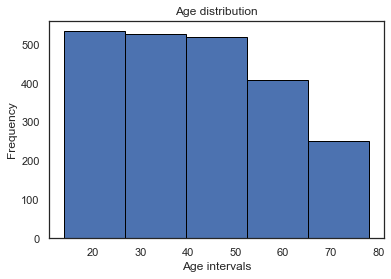

In [328]:
#Plot new variables
fig, ax=plt.subplots()

#Age is variable being plotted
ax.hist(cli_owners96['Age'], edgecolor = 'black', bins=5)

#Set title of graph
ax.set_title("Age distribution")

#Set Age groups
ax.set_xlabel("Age intervals")

#Set frequency amounts
ax.set_ylabel("Frequency")

#Plot new variables to analyse Age distribution of bank clients
plt.show()

The above chart shows the age distribution of OWNER clients within the bank (we can notice that no clients make it to 80 years of age).

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


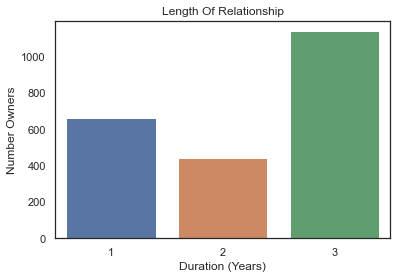

In [329]:
# Plot new variables

# Lor is variable being plotted
sns.countplot(cli_owners96['lor'])

#Set title of graph
plt.title('Length Of Relationship')

#Set Duration (Years)
plt.xlabel('Duration (Years)')

#Set Number Owner
plt.ylabel('Number Owners')
plt.show()


In [330]:
# New lor_card_m with not zeros
cli_owners96['lor_card_m_'] = cli_owners96['lor_card_m']

# Replaced 0 with nan
cli_owners96['lor_card_m_'] = cli_owners96['lor_card_m_'].replace({0:np.nan})

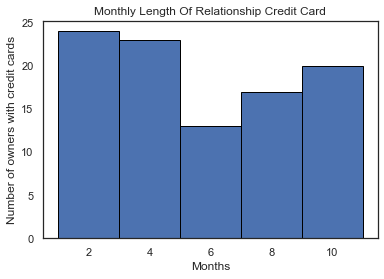

In [331]:
# Monthly Length Of Relationship Credit Card is variable being plotted
fig, ax=plt.subplots()

# lor_card_m_ is variable being plotted
ax.hist(cli_owners96['lor_card_m_'], edgecolor = 'black', bins=5)

#Set title of graph
plt.title('Monthly Length Of Relationship Credit Card')

#Set Months
plt.xlabel('Months')

#Set Number of owners with credit cards
plt.ylabel('Number of owners with credit cards')

# #Plot new variables to analyse Age distribution of bank clients
plt.show()


C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


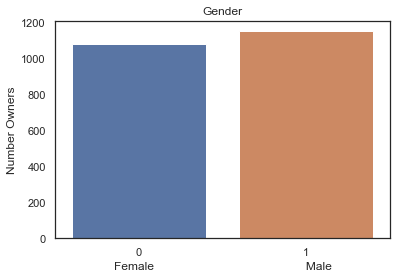

In [332]:
# gender_M variable being plotted
sns.countplot(cli_owners96['gender_M'])

#Set title of graph
plt.title('Gender')

#Set Gender
plt.xlabel('Female                                             Male')

#Set Number Owner
plt.ylabel('Number Owners')
plt.show()


In [333]:
# New avg_salary_ with not zeros
cli_owners96['avg_salary_'] = cli_owners96['avg_salary']

# Replaced 0 with nan
cli_owners96['avg_salary_'] = cli_owners96['avg_salary_'].replace({0:np.nan})

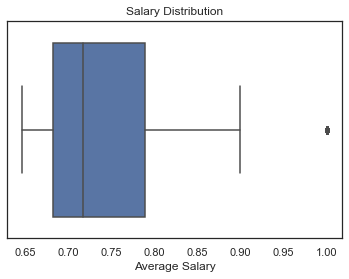

In [334]:
# avg_salary_ variable being plotted
sns.boxplot(x='avg_salary_', data=cli_owners96)

# Set title of graph
plt.title('Salary Distribution')

# Set Duration (Years) 
plt.xlabel('Average Salary')

plt.show()

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


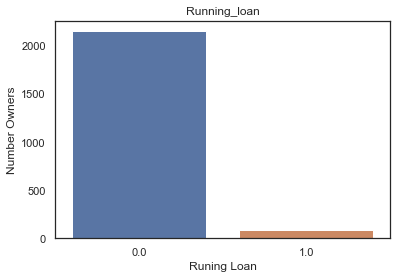

In [335]:
# running_loan variable being plotted
sns.countplot(cli_owners96['running_loan'])

#Set title of graph
plt.title('Running_loan')

#Set Runing Loan
plt.xlabel('Runing Loan')

#Set Number Owner
plt.ylabel('Number Owners')

plt.show()

In [336]:
# New loan_duration_ with not zeros
cli_owners96['loan_duration_'] = cli_owners96['loan_duration']

# Replaced 0 with nan
cli_owners96['loan_duration_'] = cli_owners96['loan_duration_'].replace({0:np.nan})

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


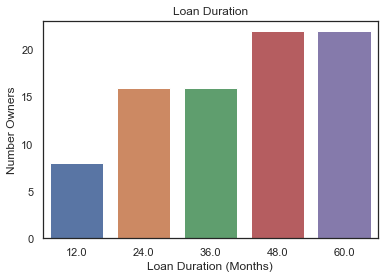

In [337]:
# loan_duration_ variable being plotted
sns.countplot(cli_owners96['loan_duration_'])

#Set title of graph
plt.title('Loan Duration')

#Set Loan Duration (Months)
plt.xlabel('Loan Duration (Months)')

#Set Number Owner
plt.ylabel('Number Owners')
plt.show()

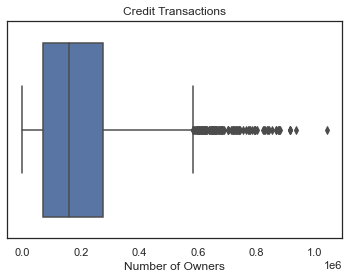

In [338]:
# Credit_transac variable being plotted
sns.boxplot(x='Credit_transac', data=cli_owners96)

# Set title of graph
plt.title('Credit Transactions')

# Set Number of Owners
plt.xlabel('Number of Owners')
plt.show()

In [339]:
# New Withdrawal_transac_ with not zeros
cli_owners96['Withdrawal_transac_'] = cli_owners96['Withdrawal_transac']

# Replaced 0 with nan
cli_owners96['Withdrawal_transac_'] = cli_owners96['Withdrawal_transac_'].replace({0:np.nan})

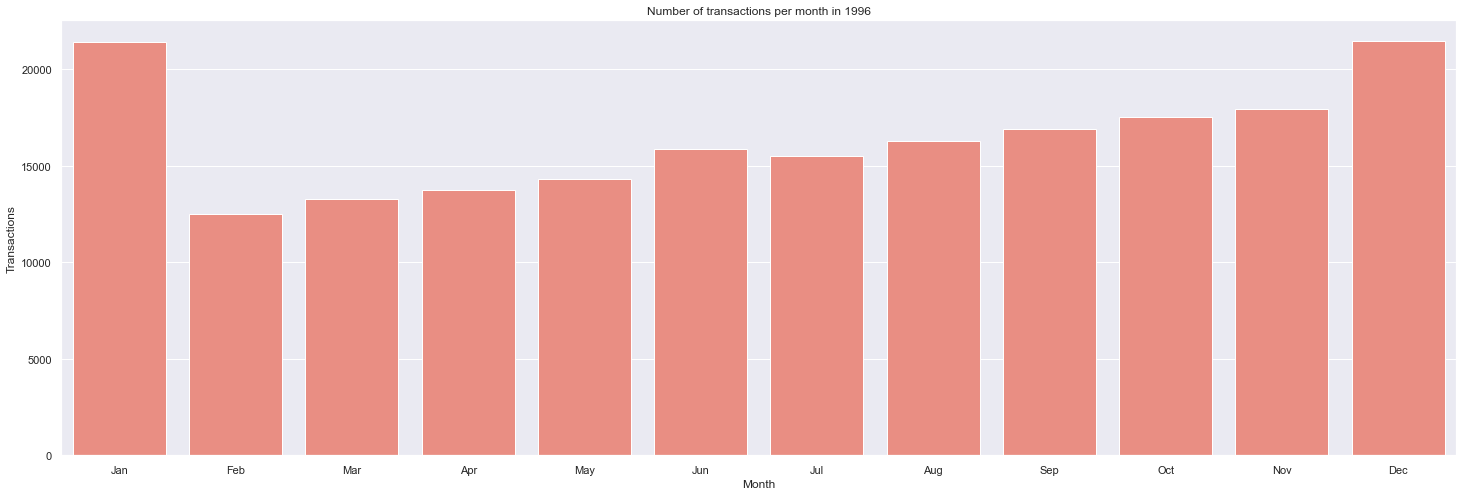

In [349]:
#Grouped table with transactions per month
gr_num_trans=pd.DataFrame(trans96.groupby(['trans_month'])['trans_id'].count()).reset_index()
gr_num_trans['trans_month']=gr_num_trans['trans_month'].astype(str)

#Plot number of transactions per month
sns.set(font_scale=1)
fig, ax=plt.subplots()
fig.set_size_inches(25,8)
ax = sns.barplot(x="trans_month", y="trans_id", color="salmon", data=gr_num_trans)
ax.set_title("Number of transactions per month in 1996")
#Set Number of Owners
ax.set_xlabel("Month")
#Set Transactions amounts
ax.set_ylabel("Transactions")
plt.xticks(range(0,12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

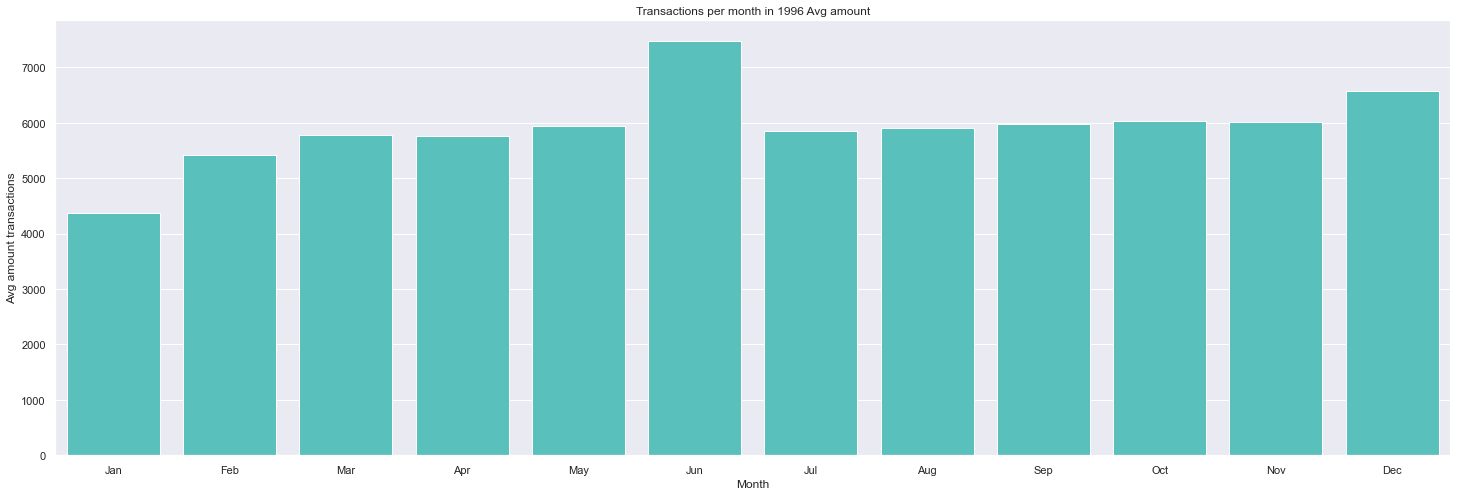

In [358]:
#Grouped table with transactions per month
gr_avg_trans=pd.DataFrame(trans96.groupby(['trans_month'])['amount'].mean()).reset_index()
gr_avg_trans['trans_month']=gr_avg_trans['trans_month'].astype(str)

#Plot number of transactions per month
sns.set(font_scale=1)
fig, ax=plt.subplots()
fig.set_size_inches(25,8)
ax = sns.barplot(x="trans_month", y="amount", color="mediumturquoise", data=gr_avg_trans)
ax.set_title("Transactions per month in 1996 Avg amount")
#Set Number of Owners
ax.set_xlabel("Month")
#Set Transactions amounts
ax.set_ylabel("Avg amount transactions")
plt.xticks(range(0,12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

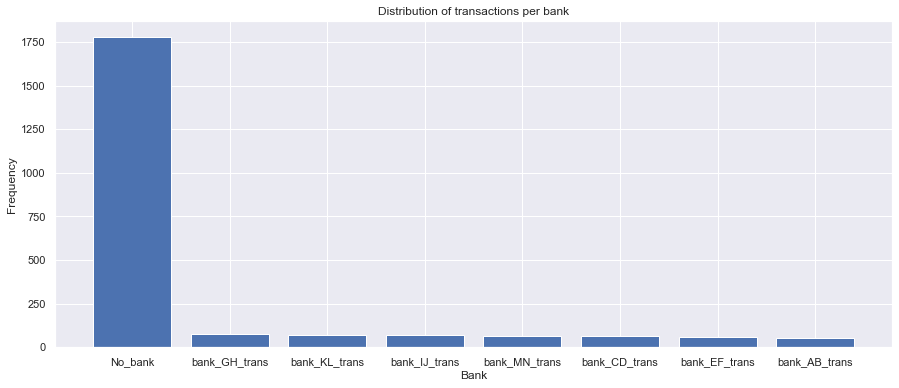

In [359]:
#Combining bank transfer variables
banks_list=pd.DataFrame(cli_owners96[['bank_AB_trans', 'bank_CD_trans', 'bank_EF_trans', 'bank_GH_trans', 'bank_IJ_trans', 'bank_KL_trans', 'bank_MN_trans', 'No_bank']].idxmax(axis=1))

banks_gr=pd.DataFrame(banks_list[0].value_counts()).reset_index()

#Plot new variables
fig, ax=plt.subplots()
fig.set_size_inches(15,6)

#Age is variable being plotted
ax.bar(banks_gr['index'],banks_gr[0])

#Set title of graph
ax.set_title("Distribution of transactions per bank")

#Set Age groups
ax.set_xlabel("Bank")

#Set frequency amounts
ax.set_ylabel("Frequency")

#Plot new variables to analyse Age distribution of bank clients
plt.show()

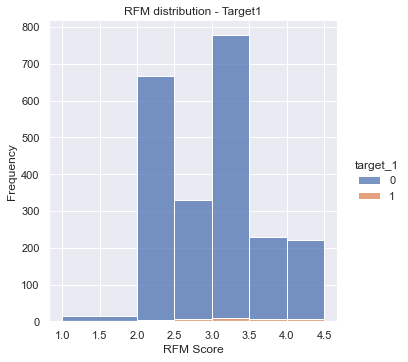

In [360]:
#Plotting target 1 vs rfm score
cli_owners96['target_1']=cli_owners96['target_1'].astype(int)
ax=sns.displot(data=cli_owners96, hue="target_1",x='rfm_score',multiple="stack", bins=[1,2,2.5,3,3.5,4,4.5])
ax.set(xlabel='RFM Score', ylabel='Frequency', title='RFM distribution - Target1')

plt.show()

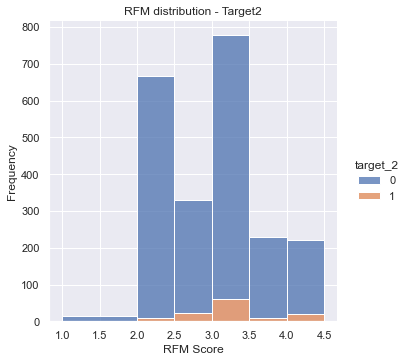

In [361]:
#Plotting targe 2 vs rfm score
cli_owners96['target_2']=cli_owners96['target_2'].astype(int)
ax=sns.displot(data=cli_owners96, hue="target_2",x='rfm_score',multiple="stack", bins=[1,2,2.5,3,3.5,4,4.5])
ax.set(xlabel='RFM Score', ylabel='Frequency', title='RFM distribution - Target2')

plt.show()

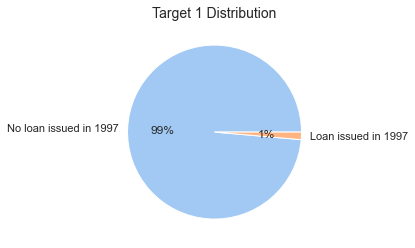

In [362]:
#Grouped information of targets- target 1
target1_gr=(cli_owners96['target_1'].value_counts())
labels = ['No loan issued in 1997','Loan issued in 1997']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:2]

plt.pie(target1_gr, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Target 1 Distribution", fontsize=14)
plt.show()

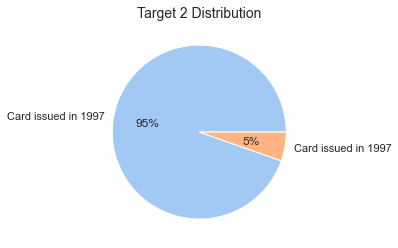

In [363]:
#Grouped information of targets -  target 2
target1_gr=(cli_owners96['target_2'].value_counts())
labels = ['Card issued in 1997','Card issued in 1997']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:2]

plt.pie(target1_gr, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Target 2 Distribution", fontsize=14)

plt.show()

<AxesSubplot:>

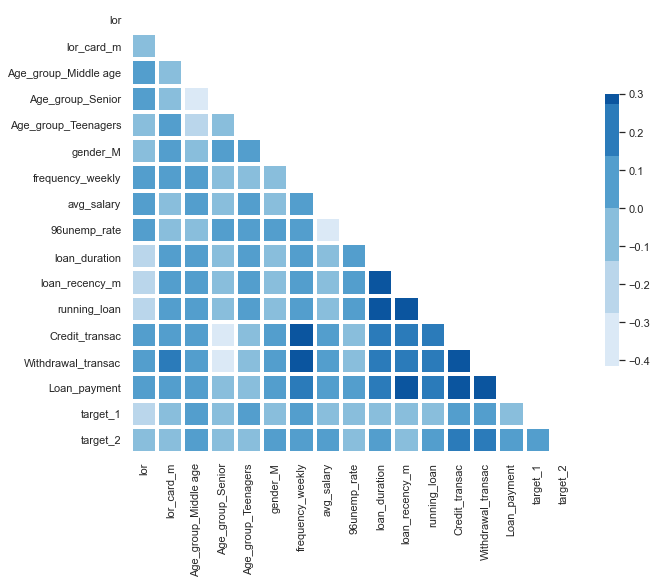

In [364]:
#Correlation matrix for some features
sns.set_theme(style="white")
corr = cli_owners96[['lor', 'lor_card_m', 'Age_group_Middle age', 'Age_group_Senior', 'Age_group_Teenagers',
                    'gender_M',  'frequency_weekly', 'avg_salary', '96unemp_rate',
                     'loan_duration','loan_recency_m', 'running_loan', 'Credit_transac', 'Withdrawal_transac', 
                     'Loan_payment','target_1','target_2']].corr()
mask = np.triu(cli_owners96[['lor', 'lor_card_m', 'Age_group_Middle age', 'Age_group_Senior', 'Age_group_Teenagers',
                    'gender_M', 'frequency_weekly', 'avg_salary', '96unemp_rate',
                     'loan_duration','loan_recency_m', 'running_loan', 'Credit_transac', 'Withdrawal_transac', 
                     'Loan_payment','target_1','target_2']].corr())
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.color_palette("Blues")

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )

In [365]:
# Exporting the cli_owners96 as csv
cli_owners96.to_csv("./Final_Base_Table.csv")